<a href="https://colab.research.google.com/github/AnupJoseph/Knowledge-Graph/blob/master/Walktrap%2CPageRank_User_Product_Similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install python-igraph cairocffi

In [0]:
import re
import pandas as pd
import numpy as np
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

import itertools
import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm
import cairocffi
import igraph

pd.set_option('display.max_colwidth', 200)
%matplotlib inline
nlp = spacy.load('en_core_web_sm')

In [0]:
def jaccard_similarity(Productlist1, Productlist2):
    s1 = set(Productlist1)
    s2 = set(Productlist2)
    return float(len(s1.intersection(s2)) / len(s1.union(s2)))

In [0]:
dataset = pd.read_csv('Final_data_search.csv',na_filter='NaN',na_values='NaN')
dataset

,User_ID,Season_ID,Search_Term,Sorting,Course_Clicked
0,10000242,i0ckklr9hu2qsbgb4aspckdjrg,robotics,NaN,Robotics
1,355805,k133ciqjq199tm3cn8utkcjkk7,pythonforbeginners,NaN,NaN
2,10000218,k133ciqjq199tm3cn8utkcjkk7,pythonforbeginners,NaN,NaN
3,355805,k133ciqjq199tm3cn8utkcjkk7,robotics,NaN,NaN
4,10000218,k133ciqjq199tm3cn8utkcjkk7,robotics,NaN,NaN
...,...,...,...,...,...
2238,10000363,j1ipi99h8dkfusnfjerutit80u,pmpexamprepration,NaN,PMP EXAM PREPRATION
2239,10000282,n03jtrqo4rbnblfipouhptg4gn,pmp,NaN,PMP EXAM PREPRATION
2240,10000282,n03jtrqo4rbnblfipouhptg4gn,pmp,NaN,PMP EXAM PREPRATION
2241,10000081,n03jtrqo4rbnblfipouhptg4gn,pmp,NaN,NaN


In [0]:
search_term = [ term for term in dataset['Search_Term'] ]
course_list = [ course for course in dataset['Course_Clicked']]
user_list = [ user for user in dataset['User_ID']]

In [0]:
def cleaner_function(search_term):
  for index,term in enumerate(search_term):
    if type(term)!=str or term == np.nan or type(term)==float or type(term)==int :
      search_term.pop(index)
      course_list.pop(index)
      user_list.pop(index)
  return search_term
search_term = cleaner_function(search_term)
search_term.remove(np.nan)

In [0]:
#Search term to product Relation Data structure 
Product_list_dict = dict()
for index,term in enumerate(search_term):
  Product_list_dict[term] = Product_list_dict.get(term,[])
  if type(course_list[index]) == str and term != np.nan and type(term)!=float and type(term)!=int:
    Product_list_dict[term].append(course_list[index])
    
Product_list = {k: v for k, v in Product_list_dict.items() if v != []}

In [0]:
#User id to product relation data structure
User_Product_list_dict = dict()
for index,user in enumerate(user_list):
  User_Product_list_dict[user] = User_Product_list_dict.get(user,[])
  if type(course_list[index]) == str and user != np.nan and type(user)!=float:
    User_Product_list_dict[user].append(course_list[index])

User_Product_list = {k: v for k, v in User_Product_list_dict.items() if v != []}

In [0]:
products=set()
for course_list in Product_list.values():
  courses=set(course_list)
  products = products.union(courses)
Product_set = list(products)

In [0]:
subset = dict(itertools.islice(Product_list.items(),len(Product_list.items())))

In [0]:
kg_df = []
for x_element in subset.keys():
  for y_element in subset.keys():
    jaccard = jaccard_similarity(subset[x_element],subset[y_element])
    kg_df.append([x_element,y_element,jaccard])

In [0]:
#Plotting Section

In [0]:
G = nx.DiGraph()
G.add_nodes_from(subset.keys())
G.add_weighted_edges_from(kg_df)

elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >=0.3 and d['weight'] !=1]
esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <0.3 and d['weight']!=0]

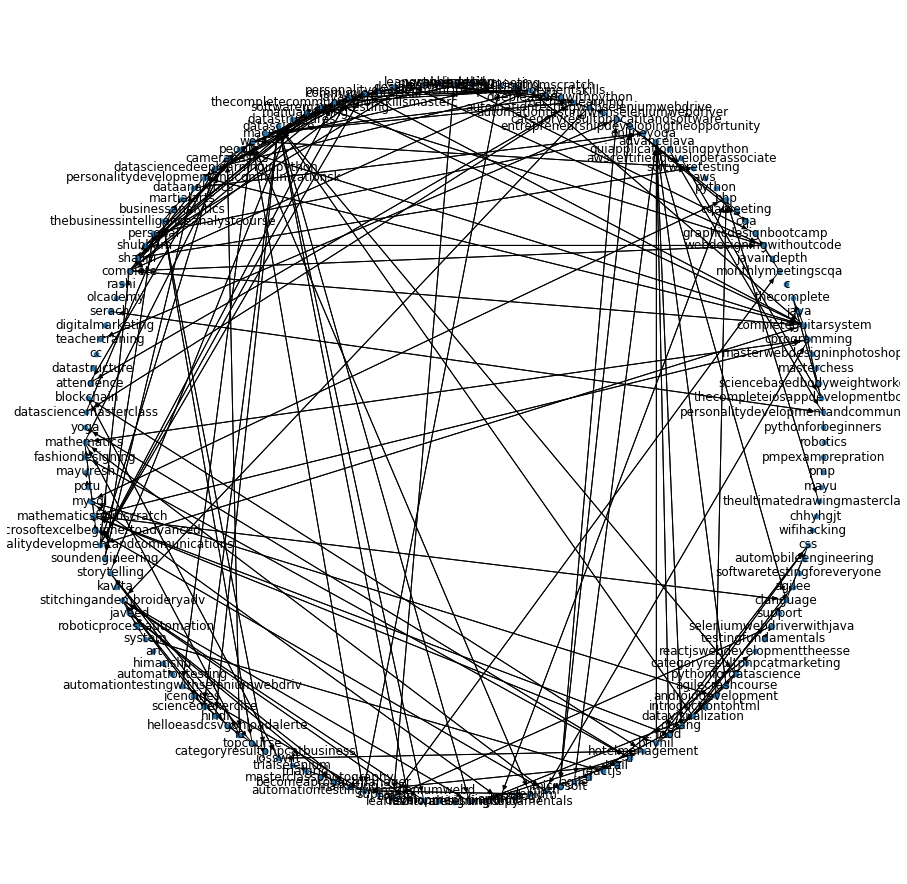

In [0]:

plt.figure(figsize=(16,16))
pos=nx.shell_layout(G) # positions for all nodes
nx.draw_networkx_nodes(G,pos,node_size=22)
nx.draw_networkx_edges(G,pos,edgelist=elarge,width=1,)
# nx.draw_networkx_edges(G,pos,edgelist=esmall,width=1,alpha=0.5,edge_color='#76ac41')
nx.draw_networkx_labels(G,pos,font_size=12,font_family='sans-serif')
pr = nx.pagerank(G,alpha=0.85)
plt.axis('off')
plt.show()

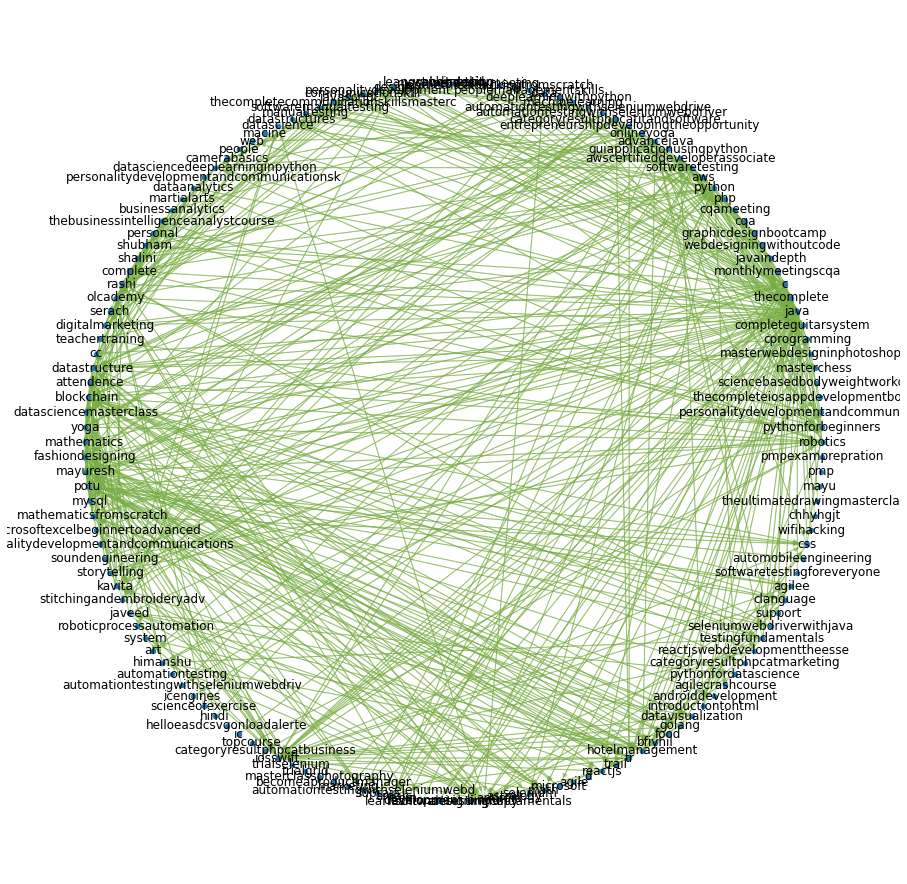

In [0]:
plt.figure(figsize=(16,16))
nx.draw_networkx_nodes(G,pos,node_size=20)
nx.draw_networkx_edges(G,pos,edgelist=esmall,width=1,alpha=0.5,edge_color='#76ac41')
nx.draw_networkx_labels(G,pos,font_size=12,font_family='sans-serif')
plt.axis('off')
plt.show()

In [0]:
#Walktrap Implementaion

In [0]:
kg = []
for edge in kg_df:
  if edge[2] == 0.0 or edge[2]==1.0 :
    pass
  else:
    kg.append(edge)

In [0]:
Gm = igraph.Graph.TupleList(kg, directed = True, edge_attrs = ['weight'])

In [0]:
mylayout = Gm.layout_fruchterman_reingold()
wtrap = Gm.community_walktrap(weights=Gm.es["weight"], steps = 5)
clust=wtrap.as_clustering()

In [0]:
print(clust)

Clustering with 144 elements and 17 clusters
[ 0] robotics, onlineyoga, categoryresultphpcatitandsoftware, dataanalytics,
     personal, teachertraning, yoga, soundengineering, introductiontohtml,
     cqa, cqameeting, entrepreneurshipdevelopingtheopportunity, microsoft
[ 1] java, masterwebdesigninphotoshop, softwaretesting, datastructure,
     monthlymeetingscqa, graphicdesignbootcamp,
     automationtestingwithseleniumwebdriver, sql, webdmeeting, rashi, cc,
     kavita, aman, softwaretestingforeveryone, wifihacking, chhyhgjt,
     automationtestingwithseleniumwebdrive, data
[ 2] c, mayuresh, cprogramming, mathematics, math, tr, arti,
     fashiondesigningcopy, microsoftexcelbeginnertoadvanced, supraja, support
[ 3] python, pythonforbeginners, webdesigningwithoutcode, attendence, design,
     olcademy, p, softwaremanualtesting, shubham, digitalmarketing, art,
     manualtesting, shalini
[ 4] awscertifieddeveloperassociate, thecompleteiosappdevelopmentbootcamp,
     thecomplete, javain

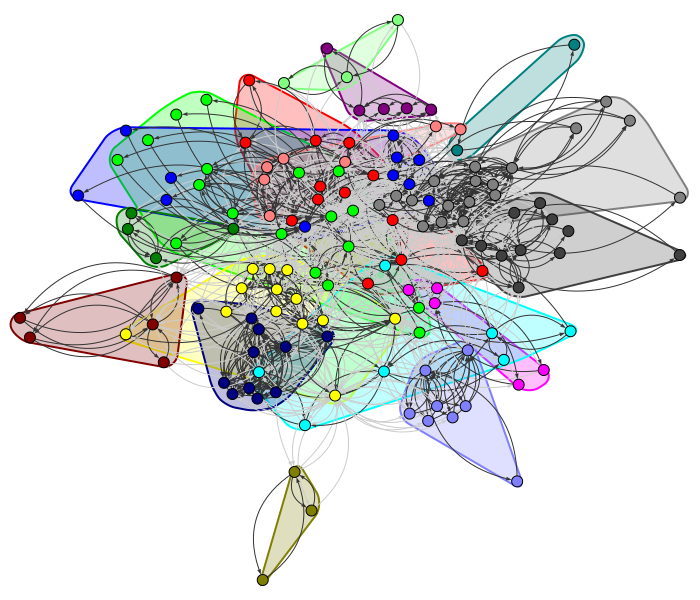

In [0]:
visual_style = {}
visual_style["bbox"] = (700,600)
# visual_style["vertex_label"] = Gm.vs["name"]
visual_style['layout'] = mylayout
visual_style['vertex_size'] = 11
visual_style['edge_arrow_size'] = 0.4
igraph.plot(clust,mark_groups = True,**visual_style)

In [0]:
containing_clusters = clust.subgraphs()

In [0]:
pagerank_arr = []
for subgraph in containing_clusters:
  temp_pagerank = subgraph.pagerank()
  temp = []
  for index,node in enumerate(subgraph.vs):
    temp.append([temp_pagerank[index],subgraph.vs[index]['name']])
  pagerank_arr.append(temp)

In [0]:
cluster_names = []
from operator import itemgetter
for index,cluster in enumerate(pagerank_arr):
  print(f'Cluster {index} ')
  cluster = sorted(cluster,key = itemgetter(0),reverse=True)
  print(f'Tag to be assigned =  {cluster[0][1]}')
  cluster_names.append([index,cluster[0][1]])
  print(cluster,sep='\n')

Cluster 0 
Tag to be assigned =  robotics
[[0.13798970987290707, 'robotics'], [0.13060462228164949, 'yoga'], [0.1004675413072823, 'onlineyoga'], [0.09252635998038138, 'entrepreneurshipdevelopingtheopportunity'], [0.089359008934229, 'categoryresultphpcatitandsoftware'], [0.08341800398436124, 'soundengineering'], [0.06849057169242292, 'personal'], [0.06849057169242291, 'dataanalytics'], [0.060357805873334044, 'cqa'], [0.05633571537137056, 'microsoft'], [0.04436932106590435, 'cqameeting'], [0.04139089973127685, 'teachertraning'], [0.026199868212457914, 'introductiontohtml']]
Cluster 1 
Tag to be assigned =  java
[[0.19897139386562845, 'java'], [0.10768768565014336, 'softwaretesting'], [0.08409995826310297, 'graphicdesignbootcamp'], [0.07708436742730498, 'kavita'], [0.06779034382047222, 'automationtestingwithseleniumwebdriver'], [0.061425172835195614, 'aman'], [0.05741572954471806, 'rashi'], [0.05043329980152904, 'monthlymeetingscqa'], [0.05043329980152903, 'webdmeeting'], [0.0415519292517

In [0]:
from collections import Counter
Product_frequency_dict={}
for search_term in Product_list:
  freq=dict(Counter(Product_list[search_term]))
  Product_frequency_dict[search_term]=freq

In [0]:
Course_list= {}
for product in Product_set:
  tagarray=[]
  for tag in cluster_names:
    temparray=[]
    for index,query in enumerate(pagerank_arr[tag[0]]):
      pro_sum = sum(Product_frequency_dict[query[1]].values())
      test = Product_frequency_dict[query[1]].get(product,0)
      Prob = test/pro_sum
      temparray.append(pagerank_arr[tag[0]][index][0]*Prob)
    tagarray.append([tag[1],sum(temparray)])
  Course_list[product]=tagarray

In [0]:
for course in Course_list:
  item_set = Course_list[course]
  tag = sorted(item_set,key=itemgetter(1),reverse=True)[0]
  print(f'Course -  {course} \t Tag - {tag[0]}')

Course -  Business Analytics 	 Tag - machinelearning
Course -  Yoga 	 Tag - robotics
Course -  Data Science: Deep Learning in Python 	 Tag - automationtestingwithseleniumwebd
Course -  Robotics 	 Tag - awscertifieddeveloperassociate
Course -  The Complete Financial Analyst Course 2019 	 Tag - topcourse
Course -  Basics of Machine learning 	 Tag - machinelearning
Course -  Selenium WebDriver with Java 	 Tag - advancejava
Course -  Python for data science 	 Tag - stitchingandembroideryadv
Course -  Web designing without code 	 Tag - stitchingandembroideryadv
Course -  WebD Daily Meeting 	 Tag - datastructures
Course -  Digital Marketing using Social Platforms 	 Tag - c
Course -  Sound Engineering 	 Tag - robotics
Course -  The Ultimate Drawing Masterclass 	 Tag - php
Course -  Fashion Designing 	 Tag - c
Course -  Selenium WebDriver with Java (Copy0) 	 Tag - java
Course -  Data structure 	 Tag - datastructures
Course -  C++ 	 Tag - c
Course -  The Business Intelligence Analyst Course 201

In [0]:
similarity_vector=[]
for test_course in Course_list:
  for rest_course in Course_list:
    similarity=0
    if test_course == rest_course:
      pass
    else:
      res=[]
      for index,tag in enumerate(Course_list[test_course]):
        res.append(Course_list[test_course][index][1]*Course_list[rest_course][index][1])
      similarity = sum(res)
    similarity_vector.append([test_course,rest_course,similarity])


In [0]:
#User tagging model

In [0]:
from collections import Counter
User_Product_frequency_dict={}
for user in User_Product_list:
  freq=dict(Counter(User_Product_list[user]))
  User_Product_frequency_dict[user]=freq

In [0]:
User_tag_list={}
for user in User_Product_list:
  tagarray = []
  for tag in cluster_names:
    user_courses = User_Product_frequency_dict[user]
    total = sum(user_courses.values())
    user_courses_probability = []
    #Calculating Probabilty for user interest in courses
    for courses in user_courses:
      user_courses_probability.append([courses,user_courses[courses]/total])

    Course_score_set = []
    for course_set in user_courses_probability:
      course = course_set[0]
      product_tag_score = Course_list.get(course,[])
      for tag_score in product_tag_score:
        if tag_score[0]==tag[1]:
          score = tag_score[1]*course_set[1]
          Course_score_set.append(score)
    tagarray.append([tag[1],sum(Course_score_set)])
  User_tag_list[user] = tagarray 

In [0]:
User_tags = {}
for users in User_tag_list:
  tag_set = User_tag_list[users]
  for tag in tag_set:
    if tag[1]>0:
      User_tags[users] = User_tags.get(users,[])
      User_tags[users].append(tag)

In [0]:
for user in User_tags:
  print('User - ',user)
  print('Assigned tags to user {} are'.format(user))
  for tag in User_tags[user]:
    print('Tag {} \t Tag score {:.6f}'.format(tag[0],tag[1]))
  print('\n') 

User -  10000242
Assigned tags to user 10000242 are
Tag robotics 	 Tag score 0.085401
Tag java 	 Tag score 0.002763
Tag c 	 Tag score 0.040252
Tag awscertifieddeveloperassociate 	 Tag score 0.096534


User -  10000218
Assigned tags to user 10000218 are
Tag robotics 	 Tag score 0.001914
Tag java 	 Tag score 0.013669
Tag python 	 Tag score 0.008070
Tag advancejava 	 Tag score 0.021937
Tag communicationskill 	 Tag score 0.009655
Tag javeed 	 Tag score 0.057555
Tag automationtestingwithseleniumwebd 	 Tag score 0.013950
Tag stitchingandembroideryadv 	 Tag score 0.015731


User -  979511
Assigned tags to user 979511 are
Tag robotics 	 Tag score 0.014512
Tag java 	 Tag score 0.047744
Tag c 	 Tag score 0.004313
Tag python 	 Tag score 0.015945
Tag awscertifieddeveloperassociate 	 Tag score 0.114515
Tag advancejava 	 Tag score 0.000942
Tag communicationskill 	 Tag score 0.017068
Tag personalitydevelopmentandcommunicationskill 	 Tag score 0.027027


User -  10000200
Assigned tags to user 10000200

In [0]:
#Rest probably not useful

In [0]:
#Rest probably not useful

In [0]:
#Rest probably not useful

In [0]:
#Rest probably not useful

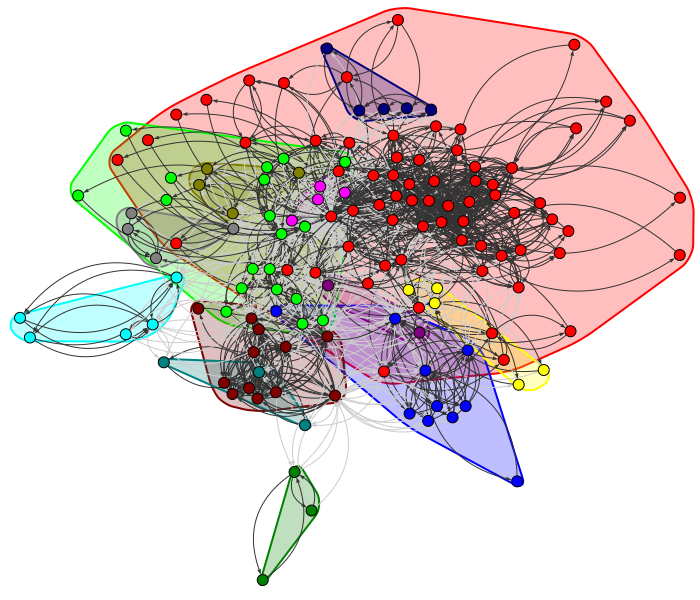

In [0]:
labelProp = Gm.community_label_propagation(weights=Gm.es["weight"])
igraph.plot(labelProp,mark_groups = True,**visual_style)

In [0]:
print(labelProp)

Clustering with 144 elements and 13 clusters
[ 0] robotics, java, categoryresultphpcatitandsoftware,
     thebusinessintelligenceanalystcourse, teachertraning, blockchain, yoga,
     mayuresh, potu, topcourse, categoryresultphpcatbusiness,
     introductiontohtml, pythonforbeginners, masterwebdesigninphotoshop,
     datastructure, storytelling, css, iosswift, cqa, cqameeting,
     entrepreneurshipdevelopingtheopportunity, himanshu, bindu,
     hotelmanagement, testingfundamentals, cprogramming, mathematics,
     mathematicsfromscratch, math, tr, advancejava, sql, rashi, cc,
     fashiondesigning, kavita, javeed, icengines, ic, becomeaproductmanager,
     marketing, microsoft, reactjs, bfiyhil, food, golang,
     reactjswebdevelopmenttheesse, seleniumwebdriverwithjava, clanguage,
     softwaretestingforeveryone, wifihacking, chhyhgjt,
     microsoftexcelbeginnertoadvanced, pythonfordatascience, agile,
     agilecrashcourse, data, datavisualization, camerabasics, system,
     categoryres